# Liberares

In [1]:
import os
import sys
import json
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import random
from sklearn.metrics import roc_auc_score, roc_curve, auc

# plotting 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# DeepLearning 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Engine

In [2]:
print(np.__version__)
print(torch.__version__)
!nvidia-smi

1.24.3
2.0.0
Thu Feb 22 09:17:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------

# Dataset

# ShapeNet 

dataset is a large and publicly available collection of 3D CAD models. It was created to facilitate research and development in the field of computer vision, particularly in tasks related to 3D object recognition, segmentation, and shape understanding. 

ShapeNet provides a diverse set of 3D models spanning various object categories, and it has been widely used in the computer vision and machine learning communities.

# Object Categories:

ShapeNet covers a broad range of object categories, including but not limited to furniture, vehicles, animals, household items, and more. Each category contains multiple 3D models representing instances of objects within that category.

# 3D Models:

Each object category in ShapeNet consists of a collection of 3D CAD models. These models are represented as triangular meshes, where each vertex has 3D coordinates (x, y, z), and the faces are defined by triangles connecting these vertices.

# Semantic Segmentation:

Some versions of the ShapeNet dataset include semantic segmentation annotations. This means that each 3D model is labeled with information about the semantic category of each part or segment of the object. This is valuable for tasks such as 3D object part segmentation.

# Dataset Splits:

The dataset is typically split into training, validation, and test sets. Researchers use these splits to train, validate, and evaluate the performance of their algorithms on various tasks.

In [3]:
DATA_FOLDER = '/kaggle/input/shapenet-core-seg/Shapenetcore_benchmark/'

class_name_id_map = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

#class_name_id_map = { 'Car': 3,'Motorbike': 10,}

class_id_name_map = {v:k for k,v in class_name_id_map.items()}

PCD_SCENE=dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False), aspectmode='data')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_split_data = json.load(open('/kaggle/input/shapenet-core-seg/Shapenetcore_benchmark/train_split.json', 'r'))
train_class_count = np.array([x[0] for x in train_split_data])

In [5]:
# plot classwise count in train set
train_dist_plots = [go.Bar(x=list(class_name_id_map.keys()), y= np.bincount(train_class_count))]

layout = dict(title="Train dataset", title_x=0.5)

fig = go.Figure(data=train_dist_plots, layout=layout)   
fig.show()

In [6]:
points_list = glob.glob("/kaggle/input/shapenet-core-seg/Shapenetcore_benchmark/04379243/points/*.npy")
print(len(points_list))

5263


In [7]:
idx = random.randint(0,len(points_list))

# load point cloud data
points = np.load(points_list[idx])
print(f"points shape = {points.shape}, min xyz = {np.min(points, axis=0)}, max xyz = {np.max(points, axis=0)}")

# load segmentation lables
seg_file_path = points_list[idx].replace('points', 'points_label').replace('.npy', '.seg')
seg_labels = np.loadtxt(seg_file_path).astype(np.int8)
print(f"seg_labels shape = {seg_labels.shape}, unique labels = {np.unique(seg_labels)}")

points shape = (2546, 3), min xyz = [-0.25123 -0.15277 -0.40435], max xyz = [0.25123 0.15277 0.40429]
seg_labels shape = (2546,), unique labels = [1 2]


# Point Cloud

point cloud is a collection of data points defined in a three-dimensional coordinate system.

Each point in the cloud represents a position in 3D space and may include additional information such as color, intensity, or other attributes associated with that point.

Point clouds are commonly obtained through 3D scanning technologies like Lidar or structured light scanners, or they can be generated synthetically.

# Coordinates:

Each point in a point cloud is defined by its x, y, and z coordinates in a three-dimensional space. These coordinates represent the position of the point in relation to a reference frame.

# Density:

The density of a point cloud refers to the number of points within a given volume of space. Higher point density generally provides more detailed representations of the surfaces or objects being captured.

# Color and Intensity:

In addition to spatial coordinates, point clouds may also include color information or intensity values associated with each point. This additional information can be derived from sensors capturing the data.

In [8]:
# append path to custom scripts
sys.path.append('/kaggle/input/visual-utills')

In [9]:
from visual_utils import plot_pc_data3d, plot_bboxes_3d

In [10]:
# there are max of 16 parts in an object in Shapenet core dataset
# creating random colors in according to part label
NUM_PARTS = 16
PART_COLORS = np.random.choice(range(255),size=(NUM_PARTS,3))
PART_COLORS0 = np.random.choice(range(255),size=(NUM_PARTS,3))

In [11]:
pc_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, color=PART_COLORS[seg_labels - 1], marker_size=2)
layout = dict(template="plotly_dark", title="Raw Point cloud", scene=PCD_SCENE, title_x=0.5)
fig = go.Figure(data=pc_plots, layout=layout)   
fig.show()

In [12]:
class ShapeNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split_type, num_samples=2500):
        self.root_dir = root_dir
        self.split_type = split_type
        self.num_samples = num_samples
        with open(os.path.join(root_dir, f'{self.split_type}_split.json'), 'r') as f:
            self.split_data = json.load(f)       
            
    def __getitem__(self, index):
        # read point cloud data
        class_id, class_name, point_cloud_path, seg_label_path = self.split_data[index]
        
        # point cloud data
        point_cloud_path = os.path.join(self.root_dir, point_cloud_path)
        pc_data = np.load(point_cloud_path)
        
        # segmentation labels
        # -1 is to change part values from [1-16] to [0-15]
        # which helps when running segmentation
        pc_seg_labels = np.loadtxt(os.path.join(self.root_dir, seg_label_path)).astype(np.int8) - 1
        #pc_seg_labels = pc_seg_labels.reshape(pc_seg_labels.size,1)
        
        # Sample fixed number of points
        num_points = pc_data.shape[0]
        if num_points < self.num_samples:
            # Duplicate random points if the number of points is less than max_num_points
            additional_indices = np.random.choice(num_points, self.num_samples - num_points, replace=True)
            pc_data = np.concatenate((pc_data, pc_data[additional_indices]), axis=0)
            pc_seg_labels = np.concatenate((pc_seg_labels, pc_seg_labels[additional_indices]), axis=0)
                
        else:
            # Randomly sample max_num_points from the available points
            random_indices = np.random.choice(num_points, self.num_samples)
            pc_data = pc_data[random_indices]
            pc_seg_labels = pc_seg_labels[random_indices]
        
        # return variable
        data_dict= {}
        data_dict['class_id'] = class_id
        data_dict['class_name'] = class_name        
        data_dict['points'] = pc_data 
        data_dict['seg_labels'] = pc_seg_labels 
        return data_dict        
                    
    def __len__(self):
        return len(self.split_data)

In [13]:
train_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='train')
val_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='val')
test_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='test')

# Show number of data for each dir 

12137
1861
2848


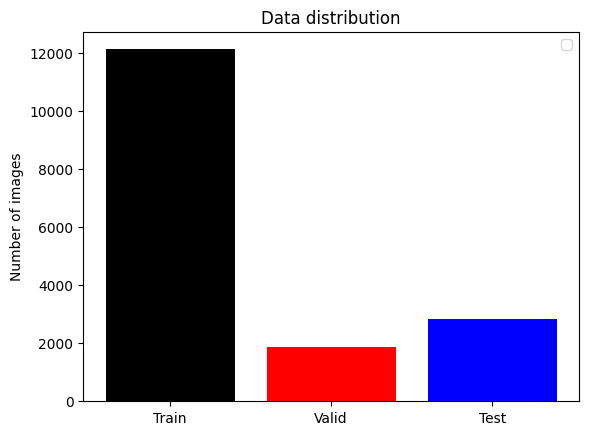

In [14]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_set), len(val_set), len(test_set)], align='center',color=[ 'black','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()

print(len(train_set))
print(len(val_set))
print(len(test_set))
showDataLayout()

In [15]:
data_dict= train_set[18]
print(f"class in dataset sample = {list(data_dict.keys())}")
points = data_dict['points']
seg_labels = data_dict['seg_labels']
print(f"class_id = {data_dict['class_id']}, class_name = {data_dict['class_name']}")

class in dataset sample = ['class_id', 'class_name', 'points', 'seg_labels']
class_id = 4, class_name = Chair


In [16]:
pc_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=True, color=PART_COLORS[seg_labels - 1], marker_size=2)
layout = dict(template="plotly_dark", title=f"{data_dict['class_name']}, class id = {data_dict['class_id']},  Shapenet Dataset", scene=PCD_SCENE, title_x=0.5)
fig = go.Figure(data=pc_plots, layout=layout)   
fig.show()

# Define how individual samples in a batch should be combined

processing a list of batch items, each containing information about a 3D point cloud

In [17]:
def collate_fn(batch_list):
    ret = {}
    ret['class_id'] =  torch.from_numpy(np.array([x['class_id'] for x in batch_list])).long()
    ret['class_name'] = np.array([x['class_name'] for x in batch_list])
    ret['points'] = torch.from_numpy(np.stack([x['points'] for x in batch_list], axis=0)).float()
    ret['seg_labels'] = torch.from_numpy(np.stack([x['seg_labels'] for x in batch_list], axis=0)).long()
    return ret

In [18]:
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=16, num_workers=2, shuffle=True, collate_fn=collate_fn) 
dataloader_iter = iter(sample_loader)   
batch_dict = next(dataloader_iter)
print(batch_dict.keys())
for key in ['points','seg_labels', 'class_id']:
    print(f"batch_dict[{key}].shape = {batch_dict[key].shape}")

dict_keys(['class_id', 'class_name', 'points', 'seg_labels'])
batch_dict[points].shape = torch.Size([16, 2500, 3])
batch_dict[seg_labels].shape = torch.Size([16, 2500])
batch_dict[class_id].shape = torch.Size([16])


In [19]:
batchSize= 64
workers = 2
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchSize, shuffle=True, num_workers=workers, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batchSize, shuffle=True, num_workers=workers, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batchSize,shuffle=True, num_workers=workers, collate_fn=collate_fn)

# Model

# PointNet

PointNet is a deep learning model designed for processing and analyzing point cloud data, which represents three-dimensional (3D) spatial information. 

Point clouds are collections of points in 3D space, often obtained from 3D sensors like LiDAR or depth cameras. 

PointNet was introduced in the paper titled "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" by Charles R. Qi, Hao Su, Kaichun Mo, and Leonidas J. Guibas, which was presented at the Conference on Computer Vision and Pattern Recognition (CVPR) in 2017.

# Input:

PointNet takes a set of 3D points as input, where each point is represented by its (x, y, z) coordinates.
The input can be a variable-sized point cloud, making PointNet applicable to different scenarios with varying numbers of points.

# Architecture:

PointNet's architecture is designed to be permutation invariant, meaning that the model's output should be the same regardless of the order of the input points. This is crucial for processing point clouds, as the order of the points may vary.
The architecture employs a shared multi-layer perceptron (MLP) network to process each point independently, extracting local features.
A symmetric function (max pooling) is then applied to aggregate information from all points into a global feature vector, capturing the overall structure of the point cloud.

# Network Components:

The PointNet architecture includes MLPs, max pooling layers, and fully connected layers.
It uses shared weights for the MLPs to ensure that each point is processed in the same way, regardless of its position in the input set.

# The Point-Net will be done in several parts :


# 1- T-Net


STN3d (Spatial Transformer Network): 

learning an affine transformation matrix that aligns the input point cloud. It consists of a series of convolutional layers followed by fully connected layers to regress the transformation matrix

In [20]:
class STN3d(nn.Module):

    def __init__(self, num_points = 2500):
        super(STN3d, self).__init__()
        self.num_points = num_points
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        
        self.mp1 = torch.nn.MaxPool1d(num_points)
        
        # FC layers
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        
        # Expected input shape = (bs, 3, num_points)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.mp1(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

In [21]:
test_model = STN3d().to(device)
sim_data = Variable(torch.rand(32,3,2500)).to(device)
out = test_model(sim_data)
print('stn', out.size())

stn torch.Size([32, 3, 3])


# OpenShape


# "OpenShape" is a  research project aimed at advancing the representation and understanding of 3D shapes in a manner that facilitates scalability and applicability to diverse shapes encountered in the open world. The goal seems to be to move beyond limited predefined categories or datasets and enable more comprehensive understanding of 3D shapes.

In [22]:
class OpenShape(nn.Module):
    def __init__(self, num_points = 2500):
        super(OpenShape, self).__init__()

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = self.mp1(x)
        return x

In [23]:
test_model = OpenShape().to(device)
sim_data = Variable(torch.rand(32,3,2500)).to(device)
out = test_model(sim_data)
print('stn', out.size())

stn torch.Size([32, 1024, 1])


# 2- FeatureNet 


PointNetfeat (Feature Extraction):

extracts features from the aligned point cloud. It utilizes the STN module to align the input point cloud and then applies a series of convolutional layers to extract local features. It also includes max-pooling to aggregate local features into a global feature representation.

In [24]:
class PointNetfeat(nn.Module):

    def __init__(self, num_points = 2500, global_feat = True):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d(num_points = num_points)
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.mp1 = torch.nn.MaxPool1d(num_points)
        self.num_points = num_points
        self.global_feat = global_feat
        self.OpenShape = OpenShape(num_points = num_points)

    def forward(self, x):
        batchsize = x.size()[0]
        trans = self.stn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans)
        x = x.transpose(2,1)
        x = F.elu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = self.mp1(x)
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, self.num_points)
            return torch.cat([x, pointfeat], 1), trans

In [25]:
pointfeat = PointNetfeat(global_feat=True).to(device)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

pointfeat = PointNetfeat(global_feat=False).to(device)
out, _ = pointfeat(sim_data)
print('point feat', out.size())

global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])


# 3- Classifier Head

PointNetCls (Classifier Head): 

classifying the input point cloud into different categories. It utilizes the features extracted by the PointNetfeat module and applies fully connected layers to produce class scores. It employs batch normalization and ReLU activation functions for better learning.

# "OOD" (Out-of-Distribution)

When performing semantic segmentation, the model is trained on a specific dataset with labeled examples of different classes or categories. During training, the model learns to classify each voxel or point in the input 3D data into one of these predefined classes. However, in real-world scenarios, the model may encounter data that is different from what it was trained on. This out-of-distribution data could include new object categories, variations in object appearance or shape, or environmental conditions not seen during training.

OOD in 3D semantic segmentation refers to the challenge of accurately segmenting objects or regions in data that fall outside the distribution of the training data. In other words, the model must be robust enough to generalize to new, unseen data while still producing accurate segmentation results.

# Train

In [26]:
def dice_score(pred, target):
    smooth = 1e-8
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

In [27]:
def train_model(model, num_epochs, criterion, optimizer, dataloader_train,
                label_str='class_id', lr_scheduler=None, output_name='pointnet.pth'):
    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        dice_scores = 0.0
        y_true = []
        y_scores = []

        for batch_dict in tqdm(dataloader_train, total=len(dataloader_train)):            
            # Forward pass
            x = batch_dict['points'].transpose(1, 2).to(device)
            labels = batch_dict[label_str].to(device)
            pred, _,_ = model(x)
            loss = criterion(pred, labels)
            train_loss += loss.item()
              
            # Calculate accuracy
            _, predicted_labels = torch.max(pred, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

            # Calculate Dice Score
            pred_binary = F.softmax(pred, dim=1)[:, 1] > 0.5  # Assuming binary classification
            dice_scores += dice_score(pred_binary, labels)

      

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()

        # compute per epoch losses, accuracy, Dice Score, and AUC
        train_loss = train_loss / len(dataloader_train)
        accuracy = correct_predictions / total_samples
        avg_dice_score = dice_scores / len(dataloader_train)


        print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:6.5f},  Dice Score: {avg_dice_score:.4f}')

    torch.save(model.state_dict(), output_name)

# Train

# Semantic Segmentation

In [28]:
'''class PointNetDenseSeg(nn.Module):
    """
    Network for Semantic Segmentation using PointNet architecture.
    """
    def __init__(self, num_points=2500, num_classes=16):
        super(PointNetDenseSeg, self).__init__()
        self.num_points = num_points
        self.num_classes = num_classes

        # Feature extraction using PointNetfeat
        self.feat = PointNetfeat(num_points, global_feat=False)

        # Additional convolutional layers for segmentation
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, num_classes, 1)  # Adjust for the number of classes
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        x, trans = self.feat(x)

        # Semantic segmentation layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)  # Output for each point

        return x, trans'''

'class PointNetDenseSeg(nn.Module):\n    """\n    Network for Semantic Segmentation using PointNet architecture.\n    """\n    def __init__(self, num_points=2500, num_classes=16):\n        super(PointNetDenseSeg, self).__init__()\n        self.num_points = num_points\n        self.num_classes = num_classes\n\n        # Feature extraction using PointNetfeat\n        self.feat = PointNetfeat(num_points, global_feat=False)\n\n        # Additional convolutional layers for segmentation\n        self.conv1 = torch.nn.Conv1d(1088, 512, 1)\n        self.conv2 = torch.nn.Conv1d(512, 256, 1)\n        self.conv3 = torch.nn.Conv1d(256, 128, 1)\n        self.conv4 = torch.nn.Conv1d(128, num_classes, 1)  # Adjust for the number of classes\n        self.bn1 = nn.BatchNorm1d(512)\n        self.bn2 = nn.BatchNorm1d(256)\n        self.bn3 = nn.BatchNorm1d(128)\n\n    def forward(self, x):\n        batchsize = x.size()[0]\n        x, trans = self.feat(x)\n\n        # Semantic segmentation layers\n       

# Semantic Segmentation with IDs

Instance IDs in 3D semantic segmentation typically refer to unique identifiers assigned to each individual object instance or region within a point cloud. These IDs help distinguish between different objects or instances in the scene.

In [29]:
class PointNetDenseSeg(nn.Module):
    def __init__(self, num_points=2500, num_classes=16, num_instances=10):
        super(PointNetDenseSeg, self).__init__()
        self.num_points = num_points
        self.num_classes = num_classes
        self.num_instances = num_instances

        # Feature extraction using PointNetfeat
        self.feat = PointNetfeat(num_points, global_feat=False)

        # Semantic segmentation layers
        self.conv1_sem = torch.nn.Conv1d(1088, 512, 1)
        self.conv2_sem = torch.nn.Conv1d(512, 256, 1)
        self.conv3_sem = torch.nn.Conv1d(256, 128, 1)
        self.conv4_sem = torch.nn.Conv1d(128, num_classes, 1)
        self.bn1_sem = nn.BatchNorm1d(512)
        self.bn2_sem = nn.BatchNorm1d(256)
        self.bn3_sem = nn.BatchNorm1d(128)

        # Instance segmentation layers
        self.conv1_inst = torch.nn.Conv1d(1088, 512, 1)
        self.conv2_inst = torch.nn.Conv1d(512, 256, 1)
        self.conv3_inst = torch.nn.Conv1d(256, 128, 1)
        self.conv4_inst = torch.nn.Conv1d(128, num_instances, 1)
        self.bn1_inst = nn.BatchNorm1d(512)
        self.bn2_inst = nn.BatchNorm1d(256)
        self.bn3_inst = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        x, trans = self.feat(x)

        # Semantic segmentation branch
        x_sem = F.relu(self.bn1_sem(self.conv1_sem(x)))
        x_sem = F.relu(self.bn2_sem(self.conv2_sem(x_sem)))
        x_sem = F.relu(self.bn3_sem(self.conv3_sem(x_sem)))
        x_sem = self.conv4_sem(x_sem)

        # Instance segmentation branch
        x_inst = F.relu(self.bn1_inst(self.conv1_inst(x)))
        x_inst = F.relu(self.bn2_inst(self.conv2_inst(x_inst)))
        x_inst = F.relu(self.bn3_inst(self.conv3_inst(x_inst)))
        x_inst = self.conv4_inst(x_inst)

        return x_sem, x_inst, trans

In [30]:
sseg = PointNetDenseSeg().to(device)
out, _,_ = sseg(sim_data)
print('sseg', out.size())

sseg torch.Size([32, 16, 2500])


In [31]:
epoch = 10
weight_decay = 1e-4
max_lr = 1e-3
num_points = 2500
num_classes = 16
criterion = nn.CrossEntropyLoss()

# create model, optimizer, lr_scheduler and pass to training function
num_classes = len(class_id_name_map.items())
classifier = PointNetDenseSeg(num_points = num_points)

# DEFINE OPTIMIZERS
optimizer = torch.optim.AdamW(classifier.parameters(), lr=max_lr, weight_decay=weight_decay)
if torch.cuda.is_available():
    classifier.cuda()

# Train

In [32]:
%%time
history = train_model(classifier, epoch, criterion, optimizer, train_loader, 
            label_str='seg_labels', output_name='pointnet_se_seg.pth')

Starting 1 epoch ...


100%|██████████| 190/190 [01:09<00:00,  2.73it/s]


Epoch: 1, Train Loss: 0.68423,  Dice Score: 0.5322
Starting 2 epoch ...


100%|██████████| 190/190 [01:08<00:00,  2.76it/s]


Epoch: 2, Train Loss: 0.38538,  Dice Score: 0.6035
Starting 3 epoch ...


100%|██████████| 190/190 [01:08<00:00,  2.76it/s]


Epoch: 3, Train Loss: 0.33639,  Dice Score: 0.5962
Starting 4 epoch ...


100%|██████████| 190/190 [01:08<00:00,  2.76it/s]


Epoch: 4, Train Loss: 0.30318,  Dice Score: 0.5901
Starting 5 epoch ...


100%|██████████| 190/190 [01:08<00:00,  2.76it/s]


Epoch: 5, Train Loss: 0.29151,  Dice Score: 0.5882
Starting 6 epoch ...


100%|██████████| 190/190 [01:08<00:00,  2.76it/s]


Epoch: 6, Train Loss: 0.27063,  Dice Score: 0.5867
Starting 7 epoch ...


100%|██████████| 190/190 [01:08<00:00,  2.76it/s]


Epoch: 7, Train Loss: 0.25926,  Dice Score: 0.5861
Starting 8 epoch ...


100%|██████████| 190/190 [01:08<00:00,  2.76it/s]


Epoch: 8, Train Loss: 0.25073,  Dice Score: 0.5849
Starting 9 epoch ...


100%|██████████| 190/190 [01:08<00:00,  2.76it/s]


Epoch: 9, Train Loss: 0.24218,  Dice Score: 0.5835
Starting 10 epoch ...


100%|██████████| 190/190 [01:08<00:00,  2.76it/s]

Epoch: 10, Train Loss: 0.23525,  Dice Score: 0.5837
CPU times: user 11min 22s, sys: 5.04 s, total: 11min 27s
Wall time: 11min 30s


# Model Test

In [33]:
classifier.load_state_dict(torch.load('pointnet_se_seg.pth'))
classifier.eval()

total_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch_dict in tqdm(test_loader, total=len(test_loader)):
        x = batch_dict['points'].transpose(1, 2).to(device)
        labels = batch_dict['seg_labels'].to(device)
        pred, _,_ = classifier(x)

        # calculate loss
        loss = criterion(pred, labels)
        total_loss += loss.item()

        # calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

evaluation_loss = total_loss / len(test_loader)
accuracy = correct_predictions / total_samples
print(evaluation_loss)
print(f"Evaluation Loss: {evaluation_loss:.4f}")
#print(f"Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 45/45 [00:12<00:00,  3.67it/s]

0.4719229347176022
Evaluation Loss: 0.4719


In [34]:
# Random test sample
test_sample = test_set[2047]
batch_dict = collate_fn([test_sample])

# Get model predictions
x = batch_dict['points'].transpose(1, 2).to(device)
model_preds, _, _ = classifier(x)
pred_part_labels = torch.argmax(model_preds, axis=1).detach().cpu().numpy()[0]

points = test_sample['points']
part_labels = test_sample['seg_labels']


# plot results
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]], column_widths=[0.5, 0.5],
                    subplot_titles=('Part Labels', 'Part Predictions'))

# ground truth part labels
part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[part_labels - 1], marker_size=2)

# ground truth part labels
pred_part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[pred_part_labels - 1], marker_size=2)

fig.update_layout(template="plotly_dark", scene=PCD_SCENE, scene2=PCD_SCENE, height = 720, width = 1280,
                title='PointNet Semantic Segmentation', title_x=0.5, title_y=0.97, margin=dict(r=0, b=0, l=0, t=0))
fig.add_trace(part_label_plots, row=1, col=1)
fig.add_trace(pred_part_label_plots, row=1, col=2)
#fig.add_trace(plot_pc_data3d(x=test_sample['points'][:,0], y=test_sample['points'][:,1], z=test_sample['points'][:,2]), row=1, col=1)
#fig.add_trace(go.Bar(x=list(class_name_id_map.keys()), y=pred_class_probs, showlegend=False), row=1, col=2)
fig.show()

In [35]:
# Random test sample
test_sample = test_set[54]
batch_dict = collate_fn([test_sample])

# Get model predictions
x = batch_dict['points'].transpose(1, 2).to(device)
pred_part_labels, pred_inst_ids, _ = classifier(x)  # Assuming the model returns both part labels and instance IDs

# Convert predictions to numpy arrays
pred_part_labels = torch.argmax(pred_part_labels, axis=1).detach().cpu().numpy()[0]
pred_inst_ids = torch.argmax(pred_inst_ids, axis=1).detach().cpu().numpy()[0]

points = test_sample['points']
part_labels = test_sample['seg_labels']

# Plot results
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]], column_widths=[0.5, 0.5],
                    subplot_titles=('Part Labels', 'Instance IDs'))

# Ground truth part labels
part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[part_labels - 1], marker_size=2)

# Predicted part labels
pred_part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[pred_part_labels - 1], marker_size=2)

# Predicted instance IDs
pred_inst_id_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS0[pred_inst_ids], marker_size=2)

fig.update_layout(template="plotly_dark", scene=PCD_SCENE, scene2=PCD_SCENE, height = 720, width = 1280,
                title='PointNet Semantic Segmentation', title_x=0.5, title_y=0.97, margin=dict(r=0, b=0, l=0, t=0))
fig.add_trace(part_label_plots, row=1, col=1)
fig.add_trace(pred_part_label_plots, row=1, col=2)
fig.add_trace(pred_inst_id_plots, row=1, col=2)  # Add predicted instance IDs
fig.show()


In [36]:
# Random test sample
test_sample = test_set[2222]
batch_dict = collate_fn([test_sample])

# Get model predictions
x = batch_dict['points'].transpose(1, 2).to(device)
pred_part_labels, pred_inst_ids, _ = classifier(x)  # Assuming the model returns both part labels and instance IDs

# Convert predictions to numpy arrays
pred_part_labels = torch.argmax(pred_part_labels, axis=1).detach().cpu().numpy()[0]
pred_inst_ids = torch.argmax(pred_inst_ids, axis=1).detach().cpu().numpy()[0]

points = test_sample['points']
part_labels = test_sample['seg_labels']

# Plot results
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]], column_widths=[0.5, 0.5],
                    subplot_titles=('Part Labels', 'Instance IDs'))

# Ground truth part labels
part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[part_labels - 1], marker_size=2, marker_symbol='circle')

# Predicted part labels
pred_part_label_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color=PART_COLORS[pred_part_labels - 1], marker_size=2, marker_symbol='square')

# Predicted instance IDs
pred_inst_id_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2], apply_color_gradient=False, 
                                  color='black', marker_size=2, marker_symbol='cross')

fig.update_layout(template="plotly_dark", scene=PCD_SCENE, scene2=PCD_SCENE, height = 720, width = 1280,
                title='PointNet Semantic Segmentation', title_x=0.5, title_y=0.97, margin=dict(r=0, b=0, l=0, t=0))
fig.add_trace(part_label_plots, row=1, col=1)
fig.add_trace(pred_part_label_plots, row=1, col=2)
fig.add_trace(pred_inst_id_plots, row=1, col=2)  # Add predicted instance IDs
fig.show()
